# Assignment 2
Deep Q Learning on Atari's Pong

## Setting Environment
We use OpenAI's gym environment. The Pong's ROM was provided by AutoROM.

In [1]:
import gym
import numpy as np
import datetime
from tensorflow import keras

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# liu
# import game rom
env = gym.make('Pong-v0')
observation = env.reset()
# status space
print(env.observation_space)
# actions space
print(env.action_space)

Box(0, 255, (210, 160, 3), uint8)
Discrete(6)


D:\Application\Anaconda\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment Pong-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/Pong-v5`.
  logger.warn(


## Process the Frames
The third element of the observation is the image frame of the game. It contains size and channels. Before any further steps, we processed the image to gray graphic.

In [4]:
def preprocess_frames(new_frame,last_frame):
    # inputs are 2 numpy 2d arrays
    n_frame = new_frame.astype(np.int32)
    n_frame[(n_frame==144)|(n_frame==109)]=0 # remove backgound colors
    l_frame = last_frame.astype(np.int32)
    l_frame[(l_frame==144)|(l_frame==109)]=0 # remove backgound colors
    diff = n_frame - l_frame
    # crop top and bot 
    diff = diff[35:195]
    # down sample 
    diff=diff[::2,::2]
    # convert to grayscale
    diff = diff[:,:,0] * 299. / 1000 + diff[:,:,1] * 587. / 1000 + diff[:,:,2] * 114. / 1000
    # rescale numbers between 0 and 1
    max_val =diff.max() if diff.max()> abs(diff.min()) else abs(diff.min())
    if max_val != 0:
        diff=diff/max_val
    return diff

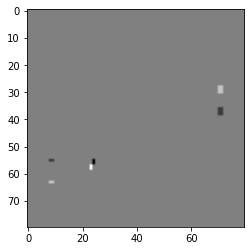

In [5]:
for i in range(30):
    observation, reward, done, info = env.step(0)# 0 means stay the same place(or do nothing)
new_observation, reward, done, info = env.step(2)
plt.imshow(preprocess_frames(new_observation,observation),plt.cm.gray)

In [6]:
preprocess_frames(new_observation,observation).shape

(80, 80)

The processed frame is 80 * 80.

## Create the Model
Using a simple 2 layer model with 200 hidden units.

In [7]:
def create_model(state_shape, action_shape):
    inputs = keras.layers.Input(shape=(80,80))
    flattened_layer = keras.layers.Flatten()(inputs)
    full_connect_1 = keras.layers.Dense(units=200,activation='relu',use_bias=False,)(flattened_layer)
    sigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(full_connect_1)
    policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
    policy_network_model.summary()
    return policy_network_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 80)]          0         
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 200)               1280000   
                                                                 
 dense_1 (Dense)             (None, 1)                 200       
                                                                 
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


The model has about 1.28 million parameters.

## Trainning
Training episode

In [8]:
def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.8
    discount_factor = 0.8

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 10
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

Because of the time and memory limit, the model is only trained for 100 episodes. In order to get workable result, the trainning episodes shall be more than 10000.

In [ ]:
train_n_times = 100 # shall be more than 10000
batch_size = 10
learning_rate = 0.8 # 0.7
epsilon = 1.
max_epsilon = 1.
min_epsilon = 0.01
decay_rate = 0.01 # 0.05

model = create_model(env.observation_space.shape, env.action_space.n)
target_model = create_model(env.observation_space.shape, env.action_space.n)
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=50_000)

target_update_counter = 0

X = []
y = []

steps_to_update_target_model = 0
for episode in range(train_episodes):
    total_training_rewards = 0
    observation = env.reset()
    done = False
    while not done:
        steps_to_update_target_model += 1

        random_number = np.random.rand()
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            encoded = observation
            encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
            predicted = model.predict(encoded_reshaped).flatten()
            action = np.argmax(predicted)
        new_observation, reward, done, info = env.step(action)
        replay_memory.append([observation, action, reward, new_observation, done])
        if steps_to_update_target_model % 4 == 0 or done:
            train(env, replay_memory, model, target_model, done)

        observation = new_observation
        total_training_rewards += reward

        if done:
            total_training_rewards += 1

            if steps_to_update_target_model >= 100:
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
env.close()

## Testing
Test the trained model against traditional computer. Display reward for every game.

In [ ]:
def test_episode(policy_network):
    env = gym.make('Pong-v0')
    done=False
    observation = env.reset()
    new_observation = observation
    while done==False:
        time.sleep(1/80)
        
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        reshaped_input = np.expand_dims(processed_network_input,axis=0)

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability])
        
        env.render()
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        if reward!=0:
            print(reward)
        if done:
            break
        
    env.close()

In [ ]:
test_episode(policy_network_model)

In [ ]:
env.close()

This model losses every game during the test. This is probably caused by the limited training time. We defined more than 1.28 millons paramaters in this model, and it requires huge amount of time to learn.

### 1.Establish a baseline performance. How well did your Deep Q-learning do on your problem? (5 Points)
<br>
train_n_times = 100
<br>
batch_size = 10
<br>
learning_rate = 0.7
<br>
epsilon = 1.
<br>
max_epsilon = 1.
<br>
min_epsilon = 0.01
<br>
decay_rate = 0.05
<br>
With this baseline setting, the model could not compete with tranditional computers.

### 2.What are the states, the actions, and the size of the Q-table? (5 Points)
<br>
The states are :
<br>
Box(0, 255, (210, 160, 3), uint8)
<br>
It is later simplified to (80, 80).
<br>
The actions are:
<br>
Discrete(6)
<br>
Because this model uses Deep Q Learning not Q Learning, there is not Q table. The network involves 2 layers, 200 hidden units, and more than 1.28 millions parameters.

### 3.What are the rewards? Why did you choose them? (5 Points)
<br>
The rewards are -1 for lose and 1 for win. The ideal of reinforcement learning is to use reward as a positive reinforce to train the model. Therefore, it is logic to use the game results for rewards.


### 4.How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?  (5 Points)
<br>
In this case I set learning rate as 0.7 and discount as (1-0.7)=0.3. I also examed with (0.8, 0.2). However, because of the time limit, the difference is limited.
<br>
Theroatically, the learning rate represent the sensitiveness of the model to new training. If the rate is too low, the model learns very slow. Otherwise, if the rate is too high, the model will be domined by only few recent trainings and become very unpredictible.

### 5.Try a policy other than e-greedy. How did it change the baseline performance? (5 Points)


### 6.How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode? (5 Points)
<br>
I set the epsilon to 1 at the start and use 0.05 as decay rate. Then I change the decay rate to 0.01.
<br>
Therotically, the decay rate influences the stabiliaty of the performence. And as the epsilon decresses the performence should become more stable and, however, unrepresentative.

### 7.What is the average number of steps taken per episode? (5 Points)
<br>
Here, because of the bad performance, the steps per episode are very low.

### 8.Does Q-learning use value-based or policy-based iteration? (5 Points)
<br>
Q-learning is a values-based learning algorithm.
<br>
Deep Q Learning, on the other hand, is a policy-based algorithm.

### 9.Could you use SARSA for this problem? (5 Points)
A SARSA can be used for this problem.
SARSA algorithm is an on-policy algorithm. The learning agent learns the value function according to the current action derived from the policy currently being used. The update equation for SARSA depends on the current state, current action, reward obtained, next state and next action.

### 10.What is meant by the expected lifetime value in the Bellman equation?
<br>
The expected lifetime value of a state can be decomposed into immediate reward plus the value of successor state with a discount factor. 
<br>
v(t)=R+y*v(t+1)

### 11.When would SARSA likely do better than Q-learning? (5 Points)
<br>
SARSA and Q-Learning are both excellent approaches for reinforcement learning problems. The two approaches work in a finite environment (or a discretized continuous environment).SARSA learns a "near" optimal policy while Q-Learning learns the optimal policy directly. Q-Learning is an aggressive agent, while SARSA is a conservative one. For example, walking near the cliff. Q-Learning will take the shortest path as optimal (with the risk of falling), while SARSA will take a longer, safer route (to avoid unexpected falling). Therefore, if the situation involves high risk or cost, SARSA can be a better option.

### 12.How does SARSA differ from Q-learning? (5 Points) 
<br>
In Q learning:
<br>
Q(st,at)←Q(st,at)+α[rt+1+γmaxaQ(st+1,a)−Q(st,at)]
<br>
SARSA:
<br>
Q(st,at)←Q(st,at)+α[rt+1+γQ(st+1,at+1)−Q(st,at)]
<br>
The biggest difference between Q-learning and SARSA is that Q-learning is off-policy, and SARSA is on-policy. SARSA is on-policy because we use the same policy to generate the current action  at  and the next action  at+1. For Q-learning, we have no constraint on how the next action is selected, only that we have this “optimistic” view that all hence-forth action selections from every state should be optimal, thus we pick the action  a  that maximizes  Q(st+1,a).

### 13.Explain the Q-learning algorithm. (5 Points) 
<br>
Q-learning is a model-free reinforcement learning algorithm.
Q-learning is a values-based learning algorithm. Value based algorithms updates the value function based on an equation(particularly Bellman equation). Whereas the other type, policy-based estimates the value function with a greedy policy obtained from the last policy improvement.
Q-learning is an off-policy learner. Means it learns the value of the optimal policy independently of the agent’s actions. 

### 14.Explain the SARSA algorithm. (5 Points) 
<br>
SARSA is an algorithm for learning a Markov decision process policy, used in the reinforcement learning area of machine learning. A SARSA agent interacts with the environment and updates the policy based on actions taken, hence this is known as an on-policy learning algorithm. The Q value for a state-action is updated by an error, adjusted by the learning rate alpha. Q values represent the possible reward received in the next time step for taking action a in state s, plus the discounted future reward received from the next state-action observation.

## References
[1]: Kavinda Kottege - DeepQ-Pong : https://github.com/KavindaKottege/DeepQ-Pong

[2]: OpenAI - gym : https://github.com/openai/gym

[3]: Wikipedia - State–action–reward–state–action : https://en.wikipedia.org/wiki/State%E2%80%93action%E2%80%93reward%E2%80%93state%E2%80%93action


## Licensing

Copyright 2022 Yuxin Liu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.